In [1]:
#%% Import necessary libraries
from glob import glob
from os import mkdir, remove
from os.path import exists, join, basename
import matplotlib.pyplot as plt
from shutil import move, rmtree
import numpy as np
import subprocess
import pickle
import time

project_folder = '/data/custom/DeepNL/insareg/snapwf_02/'
data_folder = project_folder + 'data/'
graph_folder = project_folder + 'graphs/'
output_folder = project_folder + 'output/'
sbas_output_folder = output_folder + 'sbas/'
graph2run_folder = output_folder + 'graph2run/'
geo_folder = sbas_output_folder + '01_geo/'
ifg_folder = sbas_output_folder + '02_ifg/'
log_folder = output_folder + 'log/'

mk_folder =[output_folder, graph2run_folder, sbas_output_folder,
            geo_folder, ifg_folder, log_folder]

for i in mk_folder:
    if not exists(i):
        mkdir(i)

# Get the data files
data_files = glob(data_folder + '/*.zip')

######### Set the processing parameters #########
GPT = "/opt/snap/bin/gpt"
CACHE = '200G'
CPU = '20'
JVMemMax = '-Xmx200G'

one_graph = graph_folder + 'sbas.xml'
one_graph2run = graph2run_folder + 'sbas2run.xml'

######### Define function to run the graphs #########
def rungraph(graph, GPT, CACHE, CPU, JVMemMax, message=''):
    timeStarted = time.time()
    
    # Define the computing resources that will be used
    args = [GPT, '-J' + JVMemMax, graph, '-c', CACHE, '-q', CPU] 
    # args = [GPT, graph, '-c', CACHE, '-q', CPU]
    # args = [GPT, graph]
    
    # Launch the processing
    process = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    
    stdout = process.communicate()[0]
    print('SNAP STDOUT:{}'.format(stdout))
    print(process.returncode)
    timeDelta = time.time() - timeStarted

    print('Finished process in ' + str(timeDelta) + ' seconds.')
    print('Finished process in : {} seconds\n'.format(timeDelta))

    if process.returncode != 0:
        message = 'Error after {} sec!!!'.format(timeDelta) +  message + '.\n'
    else:
        message = 'Successfully completed in {} sec!!! '.format(timeDelta) + message + '.\n'
    
    return process.returncode, message

In [2]:
#%% Apply the workflow to calculate the interferogram for each subswath
###### Get the interferogram pairs to be processed ######
ifg_pairs = []

with open(join(data_folder, 'sbas_inter_pairs.pkl'), 'rb') as f:
    inter_pairs = pickle.load(f)

for i in inter_pairs:
    slave1 = i[0]
    slave1_nm = '%s%s.zip'%(data_folder, slave1[:-4])
    
    slave2 = i[1]
    slave2_nm = '%s%s.zip'%(data_folder, slave2[:-4])
    
    t_bl = i[2]; p_bl = i[3] 
    t_bl_s1 = i[4]; p_bl_s1 = i[5]
    t_bl_s2 = i[6]; p_bl_s2 = i[7]
    
    # print("Slave 1: ", slave1_nm,  "Slave 2: ", slave2_nm)
    if exists(slave1_nm) and exists(slave2_nm):
        ifg_pairs.append([slave1_nm, slave2_nm, t_bl, p_bl, 
                          t_bl_s1, p_bl_s1, t_bl_s2, p_bl_s2])

        print("Slave 1: ", slave1_nm,  "Slave 2: ", slave2_nm)
print('-----------------------------------')

Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20151220T155541_20151220T155609_009127_00D200_592C.zip
Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20160113T155540_20160113T155608_009477_00DC01_C8CD.zip
Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20160206T155540_20160206T155607_009827_00E62A_6625.zip
Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20160301T155539_20160301T155607_010177_00F047_BDD2.zip


In [3]:
#%% Save the interferogram pairs as pickle file for plotting
pickle_file = join(data_folder, 'sbas_pairs.pkl')
with open(pickle_file, 'wb') as f:
    pickle.dump(ifg_pairs, f)

Text(0.5, 1.0, 'Temporal vs. Perpendicular Baselines of the Interferograms')

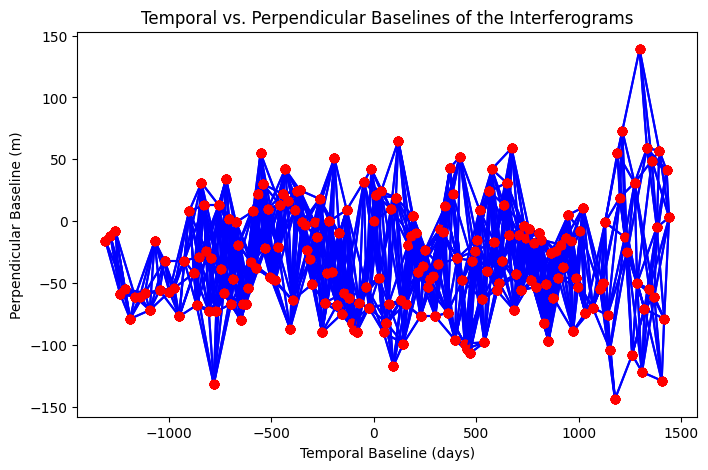

In [4]:
#%% Plot the network of the interferograms
plt.figure(figsize=(8,5), dpi=100)
for i in ifg_pairs:
    plt.plot([i[4], i[6]], [i[5], i[7]], 'b-')
    plt.plot(i[4], i[5], 'ro')
    plt.plot(i[6], i[7], 'ro')
plt.xlabel('Temporal Baseline (days)')
plt.ylabel('Perpendicular Baseline (m)')
plt.title('Temporal vs. Perpendicular Baselines of the Interferograms')    


In [ ]:
#%% Apply the one graph workflow to calculate the interferogram and the backgeocoding
#Open log file to write the processing status
log_file = log_folder + 'log_sbas.txt'

# If the log file exists, remove it and create a new one
if exists(log_file):
    remove(log_file)

with open(log_file, 'w') as log:
    log.write('-----------------------------------------------\n')
              
for slave_pair in ifg_pairs:
    slave1 = slave_pair[0]
    slave2 = slave_pair[1]
    
    slave1_date = slave1.split('/')[-1][17:25]
    slave2_date = slave2.split('/')[-1][17:25]
    
    output_geo_folder = geo_folder + slave1_date + '-' + slave2_date + '/'
    output_ifg_folder = ifg_folder + slave1_date + '-' + slave2_date + '/'
    
    output_folder_list = [output_geo_folder, output_ifg_folder]
    
    output_ifg_dim = output_ifg_folder + slave1_date + '-' + slave2_date + '_Ifg.dim'
    output_ifg_data = output_ifg_dim.replace('.dim', '.data')
    
    output_geo_dim = output_geo_folder + slave1_date + '-' + slave2_date + '_Geo.dim'
    output_geo_data = output_geo_dim.replace('.dim', '.data')
    
    for i in output_folder_list:
        if not exists(i):
            mkdir(i)
    
    #Print the processing files to the log file        
    with open(log_file, 'a') as log:
            log.write('-----------------------------------------------\n')
            log.write("Slave 1: " + slave1 + '\n')
            log.write("Slave 2: " + slave2 + '\n')
            log.write('Merged Back-Geocoding file: ' + output_geo_dim + '\n')
            log.write('Interferogram file: ' + output_ifg_dim + '\n')
            log.write('---------------- Processing -------------------\n')
    
    # Print the processing files to the screen
    print('-----------------------------------------------')
    print("Slave 1: ", slave1)
    print("Slave 2: ", slave2)
    print('Merged Back-Geocoding file: ', output_geo_dim)
    print('Interferogram file: ', output_ifg_dim)
    print('---------------- Processing -------------------')
    
    with open(one_graph, 'r') as graph2read:
        graph = graph2read.read()
        graph = graph.replace('INPUTSLAVE1', slave1)
        graph = graph.replace('INPUTSLAVE2', slave2)
        graph = graph.replace('OUTPUTBGMRG', output_geo_dim)
        graph = graph.replace('OUTPUTIFGMLFLT', output_ifg_dim)
        
    with open(one_graph2run, 'w') as graph2write:
        graph2write.write(graph)
        
    # Check if the output_ifg_iw file exists and if not run the graph
    if not exists(output_ifg_dim) or not exists(output_geo_dim):
        print('--> Running the graph')
        proc_stat, message = rungraph(one_graph2run, GPT, CACHE, CPU, 
                             JVMemMax, 'Interferogram and Back-Geocoding')
        print(message)
        
        # Write the processing status to the log file
        with open(log_file, 'a') as log:
            log.write(message)
            log.write('-----------------------------------------------\n')
        
        if proc_stat != 0:
            print('Removing output file')
            remove(output_geo_dim)
            rmtree(output_geo_data)
            remove(output_ifg_dim)
            rmtree(output_ifg_data)
            continue
        
    else:
        print(output_geo_dim + ': Back-Geocoding already exists')
        print(output_ifg_dim + ': Interferogram already exists')

        with open(log_file, 'a') as log:
            log.write(output_geo_dim + ': Back-Geocoding already exists' + '\n')
            log.write(output_ifg_dim + ': Interferogram already exists' + '\n')
            log.write('-----------------------------------------------\n')
print('------------ Process Finished -----------------')    

-----------------------------------------------
Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151126T155610_008777_00C835_5DF3.zip
Slave 2:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SDV_20151220T155541_20151220T155609_009127_00D200_592C.zip
Merged Back-Geocoding file:  /data/custom/DeepNL/insareg/snapwf_02/output/sbas/01_geo/20151126-20151220/20151126-20151220_Geo.dim
Interferogram file:  /data/custom/DeepNL/insareg/snapwf_02/output/sbas/02_ifg/20151126-20151220/20151126-20151220_Ifg.dim
---------------- Processing -------------------
/data/custom/DeepNL/insareg/snapwf_02/output/sbas/01_geo/20151126-20151220/20151126-20151220_Geo.dim: Back-Geocoding already exists
/data/custom/DeepNL/insareg/snapwf_02/output/sbas/02_ifg/20151126-20151220/20151126-20151220_Ifg.dim: Interferogram already exists
-----------------------------------------------
Slave 1:  /data/custom/DeepNL/insareg/snapwf_02/data/S1A_IW_SLC__1SSV_20151126T155542_20151